# EDA of Correlations within Data

In [2]:
import h5py

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
# plt.style.use('../histograms.mplstyle')

import scipy.stats
import scipy.optimize

from matplotlib         import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator
from math import pi

In [3]:
PLOT_PATH   = "./plots/"
PLOT_PREFIX = "correlations_"
PLOT_EXT    = ".png"

## Brief data inspection

In [4]:
# path to data file
FILE_NAME = "../data/RUN000054_1_channels.h5"
# get keys
f = h5py.File(FILE_NAME, "r")
keys = f.keys()

# build the dataset by concatenating all channels together
df = pd.concat(
    [
        pd.read_hdf(FILE_NAME, key=k, mode="r") for k in keys
    ],
    ignore_index=True
)

# rename columns
df = df.rename(columns={"CH":"ch", "HIT_DRIFT_TIME":"drift_time", "THETA":"theta", "D_WIRE_HIT":"d_wire"})

print(f"Shape: {df.shape}")
print(f'Features: {list(df.columns)}')

Shape: (1059979, 5)
Features: ['ch', 'drift_time', 'd_wire', 'm', 'theta']


### Visualization

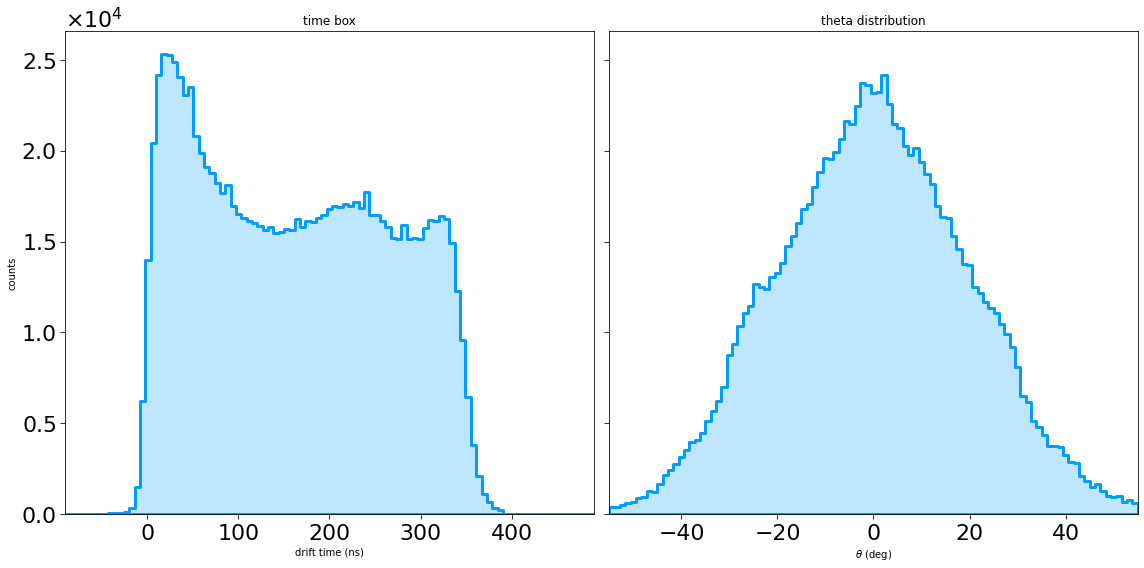

In [5]:
# BINS:
# drift time
dt_bins    = np.linspace(-90, 490, 100)
# theta
theta_bins = np.linspace(-55, 55 ,100)

fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharey=True)

ax[0].set_title("time box")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("counts")

ax[1].set_title("theta distribution")
ax[1].set_xlabel(r"$\theta$ (deg)")
# ax[1].set_ylabel("density")

ax[0].set_xlim(dt_bins[0], dt_bins[-1])
ax[1].set_xlim(theta_bins[0], theta_bins[-1])

# drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = dt_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[0]
)

# theta distribution
sns.histplot(
    x         = df.theta,
    bins      = theta_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[1]
)

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)

ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.get_offset_text().set_fontsize(22)

ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)
ax[1].tick_params(axis="both", which="major", labelsize=22, length=5)


fig.tight_layout()
PLOT_NAME = "distributions"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

## Cutting the angular feature

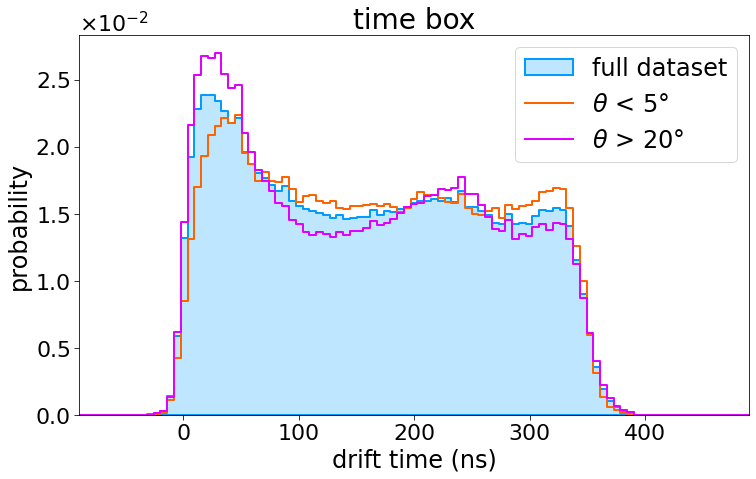

In [6]:
# binning drift time
bins = np.linspace(-90, 490, 100)
binwidth = bins[1] - bins[0]
bincenters = 0.5 * (bins[1:]+bins[:-1])

# CUTS:
# theta lower than |5°|
cut_1 = np.abs(df.theta) < 5
# theta higher than |20°|
cut_2 = np.abs(df.theta) > 20


fig, ax = plt.subplots(figsize=(12,7))

ax.set_title("time box", fontsize=28)
ax.set_xlabel("drift time (ns)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)        # using probability instead of density

ax.set_xlim(bins[0], bins[-1])


# full dataset - drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 2,
    label     = "full dataset",
    ax        = ax
)

# theta lower than |5°| - drift time distribution
sns.histplot(
    x         = df[cut_1].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#ff6300",
    linewidth = 2,
    label     = r"$\theta$ < 5°",
    ax        = ax
)

# theta higher than |20°| - drift time distribution
sns.histplot(
    x         = df[cut_2].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#e200ff",
    linewidth = 2,
    label     = r"$\theta$ > 20°",
    ax        = ax
)



# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)



ax.legend(fontsize=24)

PLOT_NAME = "simple_cut"
# fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

## Possible breakthrough: correlation with cuts

In [7]:
# list of selected values of theta 
thetas = np.arange(5, 55, 5)

# create a list of masks (cuts) that slices data if theta is less than the selected value
low_cuts = [
    np.abs(df.theta) < theta for theta in thetas
]
# create a list of masks (cuts) that slices data if theta is higher than the selected value
high_cuts = [
    np.abs(df.theta) > theta for theta in thetas
]

In [8]:
# bin the time box for each (low) cut value 
hists         = [np.histogram(df[cut].drift_time, bins=bins, density=False)[0] for cut in low_cuts]
low_hist_bins = [np.histogram( df[cut].drift_time, bins=bins, density=False )[1] for cut in low_cuts ]

bin_width = bins[1]-bins[0]
low_areas = [np.sum( bin_width * h ) for h in hists]
low_hists     = [h/ A for h, A in zip(hists,low_areas)]
low_err = [np.sqrt(h/A) for h,A in zip(low_hists,low_areas)]

# bin the time box for each (low) cut value 
hists         = [np.histogram(df[cut].drift_time, bins=bins, density=False)[0] for cut in high_cuts]
high_hist_bins = [np.histogram( df[cut].drift_time, bins=bins, density=False )[1] for cut in high_cuts ]

bin_width = bins[1]-bins[0]
high_areas = [np.sum( bin_width * h ) for h in hists]
high_hists     = [h/ A for h, A in zip(hists,high_areas)]
high_err = [np.sqrt(h/A) for h,A in zip(high_hists,high_areas)]



In [9]:
low_prob=[]
low_prob_err=[]

for h,b,e in zip(low_hists, low_hist_bins, low_err):
    bin_width = b[1]-b[0]
    bin_centers = (b[1:] + b[:-1])/2
    dic = {'bin':bin_centers, 'prob':h, 'err':e}
    d = pd.DataFrame(dic)
    sum = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['prob'].sum()
    prob=sum*bin_width
    low_prob.append(prob)
    #errors
    squared_err = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['err']**2
    sum_err = np.sqrt( np.sum(squared_err))
    prob_err = bin_width * sum_err
    low_prob_err.append(prob_err)


high_prob=[]
high_prob_err=[]

for h,b,e in zip(high_hists, high_hist_bins, high_err):
    bin_width = b[1]-b[0]
    bin_centers = (b[1:] + b[:-1])/2
    dic = {'bin':bin_centers, 'prob':h, 'err':e}
    d = pd.DataFrame(dic)
    sum = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['prob'].sum()
    prob=sum*bin_width
    high_prob.append(prob)
    #errors
    squared_err = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['err']**2
    sum_err = np.sqrt( np.sum(squared_err))
    prob_err = bin_width * sum_err
    high_prob_err.append(prob_err)




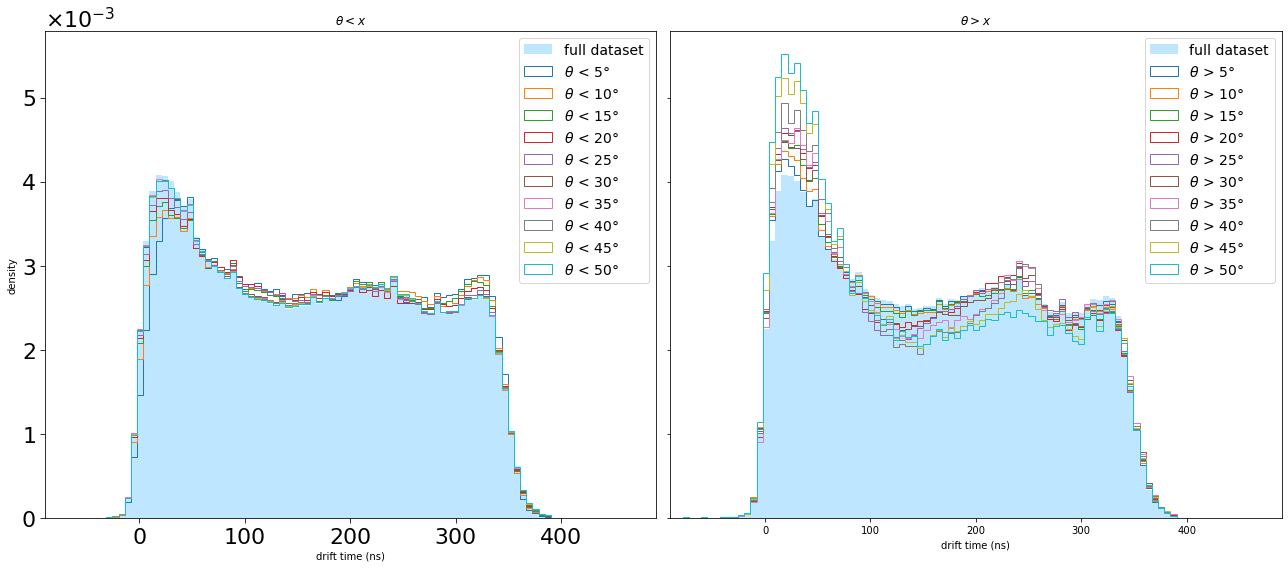

In [10]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18,8))


ax[0].set_title(r"$\theta < x$")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("density")
ax[1].set_title(r"$\theta > x$")
ax[1].set_xlabel("drift time (ns)")

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)
ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)


# x range
ax[0].set_xlim(bins[0], bins[-1])

# ------------------------------------
# FULL DATASETS FOR REFERENCE
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[0]
)
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[1]
)
# ------------------------------------

# low-cut time boxes
for h, theta in zip(low_hists, thetas):
    ax[0].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ < "+str(theta)+"°"
    )

# high-cut time boxes
for h, theta in zip(high_hists, thetas):
    ax[1].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ > "+str(theta)+"°"
    )

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

fig.tight_layout()

plt.show()

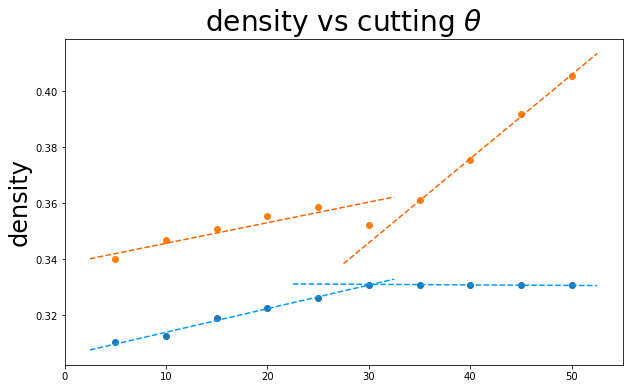

In [11]:
# linear function
def lin(x, a, b): return a + b*x
theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)

# fitting low cuts
low_small_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[:5], 
    ydata=low_prob[:5],
    sigma=low_prob_err[:5], 
    absolute_sigma=True
)

low_large_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[6:], 
    ydata=low_prob[6:],
    sigma=low_prob_err[6:], 
    absolute_sigma=True
)

# fitting high cuts
high_small_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[:6], 
    ydata=high_prob[:6],
    sigma=high_prob_err[:6], 
    absolute_sigma=True
)

high_large_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[6:], 
    ydata=high_prob[6:],
    sigma=high_prob_err[6:], 
    absolute_sigma=True
)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(r"density vs cutting $\theta$", fontsize=28)
ax.set_ylabel("density", fontsize=24)

ax.scatter(thetas, low_prob)
ax.scatter(thetas, high_prob)

# low-cut fit
ax.plot(
    np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), *low_small_par),
    linestyle = "dashed",
    color = "#009cff", 
)
ax.plot(
    np.linspace(thetas[4]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[4]-2.5, thetas[-1]+2.5, 100), *low_large_par),
    linestyle = "dashed",
    color = "#009cff", 
)

#high-cut fit
ax.plot(
    np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), *high_small_par),
    linestyle = "dashed",
    color = "#ff6300", 
)
ax.plot(
    np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), *high_large_par),
    linestyle = "dashed",
    color = "#ff6300", 
)


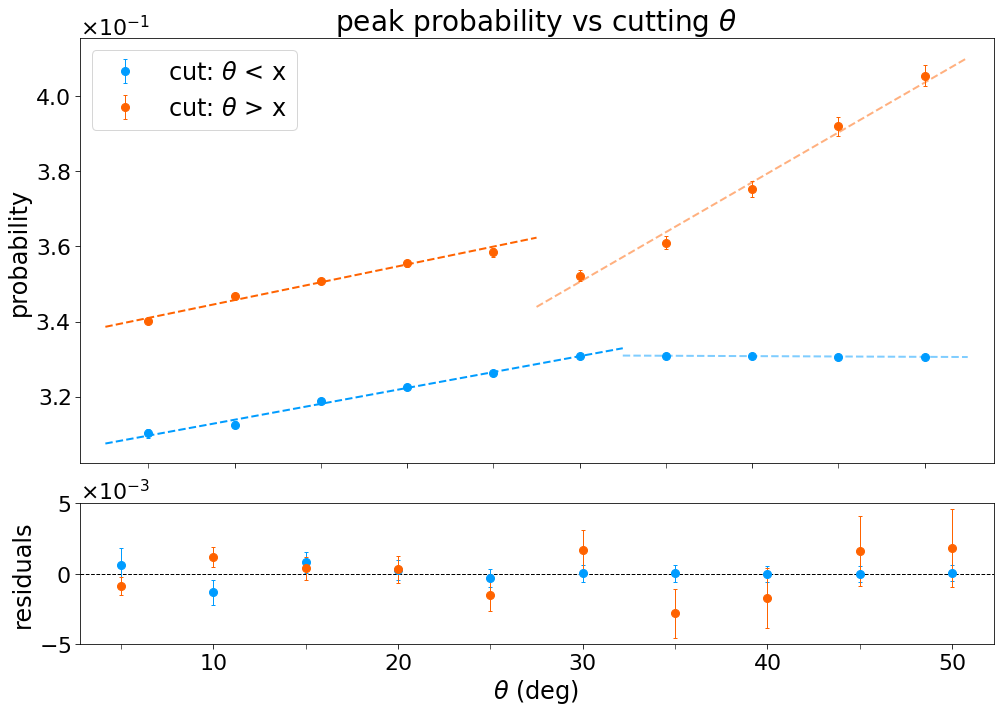

In [13]:
# linear function
def lin(x, a, b): return a + b*x

# x grid for theta values (continuous, employed in plotting the fitted function)
theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)

# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[:6], 
    ydata=low_prob[:6],
    sigma=low_prob_err[:6], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[0:5], 
    ydata=high_prob[0:5],
    sigma=high_prob_err[0:5], 
    absolute_sigma=True
)

# residuals
func = lin(np.array(thetas[:6]), *low_par)
low_res = low_prob[:6] - func
chi_low_small = np.sum( ( low_res  / low_prob_err[:6])**2 )
d_low_small = len(low_res) - len(high_par)
p_low_small = scipy.stats.chi2.sf(chi_low_small,df = d_low_small )

func = lin(np.array(thetas[0:5]), *high_par)
high_res = high_prob[0:5] - func
chi_high_small = np.sum( ( high_res  / high_prob_err[0:5] )**2)
d_high_small = len(low_res) - len(high_par)
p_high_small = scipy.stats.chi2.sf(chi_high_small,df = d_high_small) 

# TO DO: perform goodness-of-fit test (easy chi2 test)

fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$", fontsize=28)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=24)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)

ax1.set_xlim(theta_grid[0], theta_grid[-1])
# ax.set_ylim(0.01,0.039)


# exponential y ticks
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="x", which="minor", labelsize=0, length=5)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="x", which="minor", labelsize=0, length=5)

ax1.set_xticklabels([])
# ax2.set_ylim(-1.2e-3, 1.2e-3)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

# low-cut scatter
ax1.errorbar(
    x          = thetas, 
    y          = low_prob,
    yerr       = low_prob_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ < x"
)
# low-cut fit
ax1.plot(
    np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[5]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2
)

# high-cut scatter
ax1.errorbar(
    x          = thetas, 
    y          = high_prob,
    yerr       = high_prob_err,
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)
# high-cut fit
ax1.plot(
    np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2
)

# low-cut residuals
ax2.errorbar(
    x          = thetas[:6], 
    y          = low_res,
    yerr       = low_prob_err[:6],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

# high-cut residuals
ax2.errorbar(
    x          = thetas[0:5], 
    y          = high_res[0:5],
    yerr       = high_prob_err[0:5],
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ > x"
)


# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[6:], 
    ydata=low_prob[6:],
    sigma=low_prob_err[6:], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[5:], 
    ydata=high_prob[5:],
    sigma=high_prob_err[5:], 
    absolute_sigma=True
)

# residuals
func = lin(np.array(thetas[6:]), *low_par)
low_res = low_prob[6:] - func
chi_low_large = np.sum( ( low_res  / low_prob_err[6:] )**2 )
d_low_large = len(low_res) - len(low_par)
p_low_large = scipy.stats.chi2.sf(chi_low_large,df = d_low_large ) 

func = lin(np.array(thetas[5:]), *high_par)
high_res = high_prob[5:] - func
chi_high_large = np.sum( ( high_res  / high_prob_err[5:] )**2 )
d_high_large = len(high_res) - len(high_par)
p_high_large = scipy.stats.chi2.sf(chi_high_large, df = d_high_large) 

# low-cut residuals
ax2.errorbar(
    x          = thetas[6:], 
    y          = low_res,
    yerr       = low_prob_err[6:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ < x"
)

# high-cut residuals
ax2.errorbar(
    x          = thetas[5:], 
    y          = high_res,
    yerr       = high_prob_err[5:],
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ > x"
)

# low-cut fit
ax1.plot(
    np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2,
    alpha=0.5,
)
# high-cut fit
ax1.plot(
    np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=0.5,
)

ax1.legend(fontsize=24)

fig.tight_layout()

PLOT_NAME = "density_fit_cut"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [118]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
low_small_r,   low_small_p = scipy.stats.pearsonr(thetas[:6], low_prob[:6])
low_large_r,   low_large_p = scipy.stats.pearsonr(thetas[6:], low_prob[6:])

high_small_r, high_small_p = scipy.stats.pearsonr(thetas[0:5], high_prob[0:5])
high_large_r, high_large_p = scipy.stats.pearsonr(thetas[5:], high_prob[5:])

print("\nLOW CUT:")
print(f"Correlation coefficient (small theta) {low_small_r:.5f}")
print(f"p-value = {low_small_p:.2e}")

print('Chi squared', chi_low_small)
print(f"p-value of chi = {p_low_small:.2e}")
print(f"degrees of freedom = {d_low_small}")
print("Statistically significant:", "YES" if low_small_p < alpha else "NO")

print(f"Correlation coefficient (large theta) {low_large_r:.5f}")
print(f"p-value = {low_large_p:.2e}")

print('Chi squared', chi_low_large)
print(f"p-value of chi = {p_low_large:.2e}")
print(f"degrees of freedom = {d_low_large}")
print("Statistically significant:", "YES" if low_large_p < alpha else "NO")

print("\nHIGH CUT:")
print(f"Correlation coefficient (small theta) {high_small_r:.5f}")
print(f"p-value = {high_small_p:.2e}")

print('Chi squared', chi_high_small)
print(f"p-value of chi = {p_high_small:.2e}")
print(f"degrees of freedom = {d_high_small}")
print("Statistically significant:", "YES" if high_small_p < alpha else "NO")

print(f"Correlation coefficient (large theta) {high_large_r:.5f}")
print(f"p-value = {high_large_p:.2e}")

print('Chi squared', chi_high_large)
print(f"p-value of chi = {p_high_large:.2e}")
print(f"degrees of freedom = {d_high_large}")
print("Statistically significant:", "YES" if high_large_p < alpha else "NO")


LOW CUT:
Correlation coefficient (small theta) 0.99533
p-value = 3.27e-05
Chi squared 3.936091567237137
p-value of chi = 4.15e-01
degrees of freedom = 4
Statistically significant: YES
Correlation coefficient (large theta) -0.96354
p-value = 3.65e-02
Chi squared 0.010798292935066723
p-value of chi = 9.95e-01
degrees of freedom = 2
Statistically significant: YES

HIGH CUT:
Correlation coefficient (small theta) 0.98988
p-value = 1.22e-03
Chi squared 6.704368278015693
p-value of chi = 1.52e-01
degrees of freedom = 4
Statistically significant: YES
Correlation coefficient (large theta) 0.99542
p-value = 3.72e-04
Chi squared 5.572676298953896
p-value of chi = 1.34e-01
degrees of freedom = 3
Statistically significant: YES


# Intervalli $\theta_{low} < \theta_i < \theta_{up}$

In [14]:
thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
bins = np.linspace(-90,490,100)

middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low, up in zip(thetas_low,thetas_up) ]

# bin the time box for each (high) cut value 
hists          = [np.histogram(df[cut].drift_time, bins=bins, density=False)[0] for cut in middle_cut]
middle_hist_bins = [np.histogram( df[cut].drift_time, bins=bins, density=False )[1] for cut in middle_cut ]

bin_width = bins[1]-bins[0]
middle_areas = [np.sum( bin_width * h ) for h in hists]
middle_hists = [h/ A for h, A in zip(hists,middle_areas)]
middle_err = [np.sqrt(h/A) for h,A in zip(middle_hists,middle_areas)]

middle_prob=[]
middle_prob_err=[]

for h,b,e in zip(middle_hists, middle_hist_bins, middle_err):
    bin_width = b[1]-b[0]
    bin_centers = (b[1:] + b[:-1])/2
    dic = {'bin':bin_centers, 'prob':h, 'err':e}
    d = pd.DataFrame(dic)
    sum = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['prob'].sum()
    prob=sum*bin_width
    middle_prob.append(prob)
    #errors
    squared_err = d[  (d['bin'] > 0) & (d['bin'] <97)  ]['err']**2
    sum_err = np.sqrt( np.sum(squared_err))
    prob_err = bin_width * sum_err
    middle_prob_err.append(prob_err)


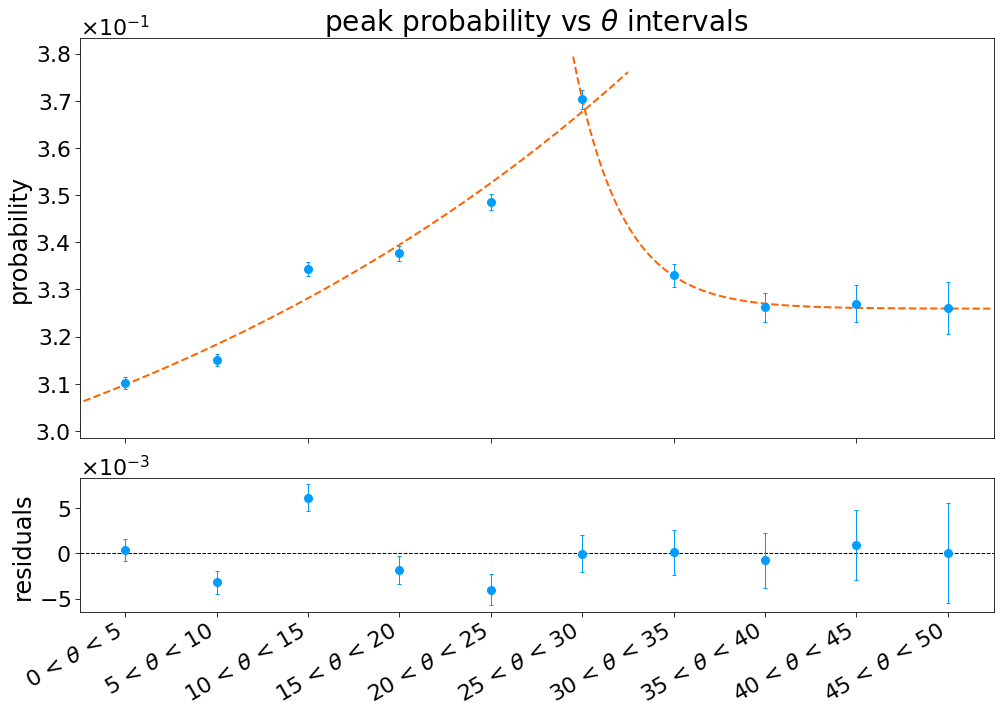

In [23]:
def expo(x, a, b, c):
    return a+b*np.exp(c*x)

def nexpo(x, a, b, c):
    return a+b*np.exp(-c*x)



thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
x_theta = np.linspace(-5,27.5,500)


xlabels = [r"%i < $\theta$ < %i"%(x1,x2) for x1, x2 in zip(thetas_low,thetas_up)]


fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs $\theta$ intervals", fontsize=28)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)
# ax1.set_xticks(thetas_low)
ax2.set_xticks(thetas_low)
ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(-2.5, 47.5)
ax2.set_xlim(-2.5, 47.5)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

ax1.errorbar(
    x=thetas_low, 
    y=middle_prob, 
    yerr=middle_prob_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=expo, 
    xdata=thetas_low[:6], 
    ydata=middle_prob[:6], 
    sigma=middle_prob_err[:6], 
    absolute_sigma=True
)


# residuals
func = expo(np.array(thetas_low[:6]), *middle_par_tot)
middle_res = middle_prob[:6] - func
chi_middle_small = np.sum( ( middle_res  / middle_prob_err[:6] )**2)
d_middle_small = len(middle_res) - len(middle_par_tot)
p_middle_small = scipy.stats.chi2.sf(chi_middle_small, df = d_middle_small) 

#  residuals
ax2.errorbar(
    x          = thetas_low[:5], 
    y          = middle_res[:5],
    yerr       = middle_prob_err[:5],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


ax1.plot(
    x_theta, 
    expo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=nexpo, 
    xdata=thetas_low[5:], 
    ydata=middle_prob[5:], 
    sigma=middle_prob_err[5:], 
    absolute_sigma=True,
    p0=[0.25453928, 0.05526842, 0.02865415],
)

# residuals
func = nexpo(np.array(thetas_low[5:]), *middle_par_tot)
middle_res = middle_prob[5:] - func
chi_middle_large = np.sum( ( middle_res  / middle_prob_err[5:] )**2)
d_middle_large = len(middle_res) - len(middle_par_tot)
p_middle_large = scipy.stats.chi2.sf(chi_middle_large, df = d_middle_large) 

#  residuals
ax2.errorbar(
    x          = thetas_low[5:], 
    y          = middle_res,
    yerr       = middle_prob_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

x_theta = np.linspace(24.5,47.5,500)

ax1.plot(
    x_theta, 
    nexpo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

# ax2.set_ylim(-2.3e-3,2.3e-3)

fig.tight_layout()

PLOT_NAME = "density_intervals"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [24]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(thetas_low, middle_prob)

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")

print("chi squared", chi_middle_small)
print("NDF", d_middle_small)
print(f"p value of chi = {p_middle_small}")
print("chi squared", chi_middle_large)
print("NDF", d_middle_large)
print(f"p value of chi = {p_middle_large}")




middle CUT:
Correlation coefficient 0.20716
p-value = 5.66e-01
Statistically significant: NO
chi squared 32.6774835944589
NDF 3
p value of chi = 3.766750266644591e-07
chi squared 0.12091412843619825
NDF 2
p value of chi = 0.9413341850700181


In [101]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(thetas_low[:4], middle_prob[:4])

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")



middle CUT:
Correlation coefficient 0.95782
p-value = 4.22e-02
Statistically significant: YES


In [29]:
from scipy.optimize import curve_fit

def lorentzian(x, A, x0, gamma):
    return A*gamma**2/(gamma**2+(x-x0)**2)

def gaussian(x, A , mean , std ):
    return A * np.exp( - ((x - mean) **2 /(2*std**2)))

x=np.linspace(0,100, 35)
bins = np.linspace(-90, 490, 100)
xx=np.linspace(x[0], x[-1], 1000)

# stima picchi con gauss

0.00408 pm 0.00002
0.00381 pm 0.00002
0.00394 pm 0.00002
0.00389 pm 0.00002
0.00412 pm 0.00002
0.00408 pm 0.00002
0.00411 pm 0.00002
0.00424 pm 0.00001
0.00424 pm 0.00001
0.00424 pm 0.00001


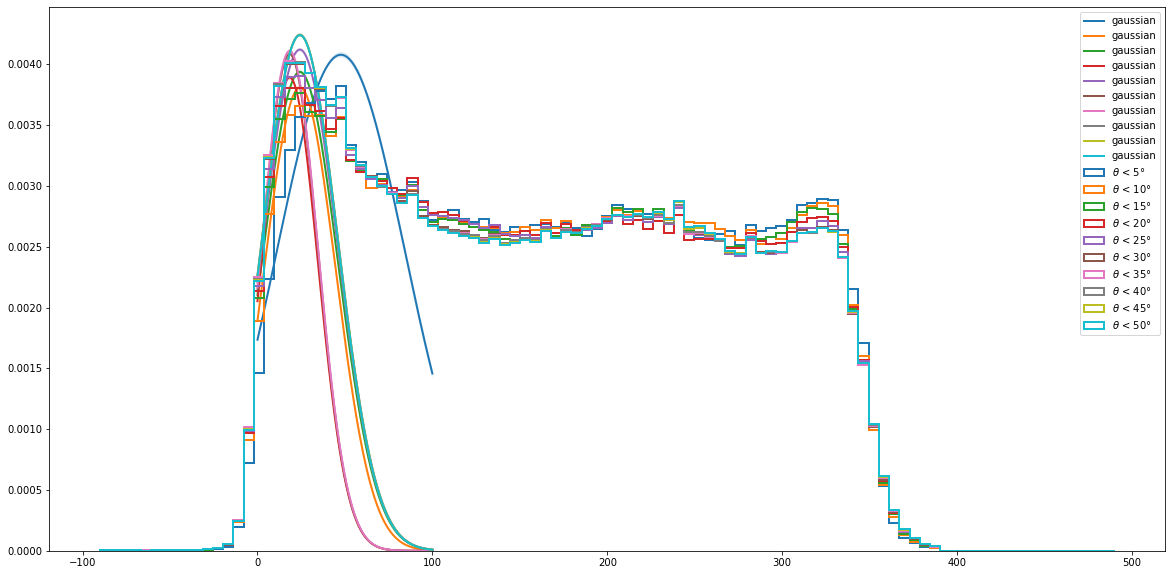

In [30]:
fig, ax = plt.subplots(figsize=(20,10))

gauss_low_peaks = []
lor_low_peaks = []
low_params=[]
gauss_low_err = []

for p,b,err in zip(low_hists, low_hist_bins, low_err):
   
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df.dropna(axis=0)
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_low_peaks.append( popt_gauss[0] )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_low_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=2, label='gaussian')
    
    bound_upper = gaussian(xx, *(popt_gauss + sigma))
    bound_lower = gaussian(xx, *(popt_gauss - sigma))
    # plotting the confidence intervals
    ax.fill_between(xx, bound_lower, bound_upper, alpha = 0.15)

for h, theta in zip(low_hists, thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        lw=2,
        label=r"$\theta$ < "+str(theta)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'], color='red')
    # ax.errorbar(x=final_df['bin_cent'], y=final_df['prob'], yerr=final_df['err'],
    #     marker     = "o",
    #     color      =  "black",
    #     linestyle  = "none",
    #     elinewidth = 1, 
    #     capsize    = 2, )

ax.legend()

for p,e in zip(gauss_low_peaks, gauss_low_err):
    print(f'{p:.5f} pm {e:.5f}')



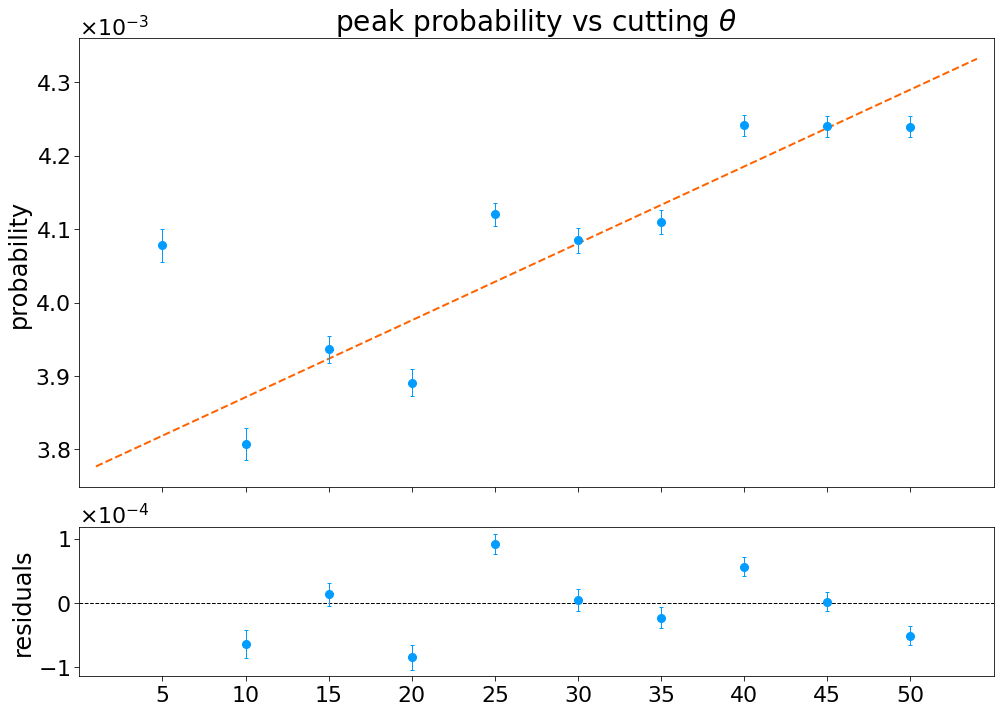

In [32]:
gauss_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[1:], 
    ydata=gauss_low_peaks[1:],
    sigma=gauss_low_err[1:],
    absolute_sigma=True
)

fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$", fontsize=28)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)
# ax1.set_xticks(thetas_low)
ax1.set_xticks(thetas)
ax2.set_xticks(thetas)
# ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(0, 55)
ax2.set_xlim(0, 55)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)
# ax.set_xlim(theta_grid[0], theta_grid[-1])

ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

ax1.errorbar(
    x          = thetas, 
    y          = gauss_low_peaks,
    yerr       = gauss_low_err,
    marker     = "o",
    color      =  "#009cff",
    markersize = 8,
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

#residuals
func = lin(np.array(thetas[1:]), *gauss_par)
low_res = gauss_low_peaks[1:] - func
chi_low = np.sum( (( low_res ) / gauss_low_err[1:] )**2 )
d_low = len(low_res) - len(gauss_par)
p_low = scipy.stats.chi2.sf(chi_low, df = d_low) 


#  residuals
ax2.errorbar(
    x          = thetas[1:], 
    y          = low_res,
    yerr       = gauss_low_err[1:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

fig.tight_layout()
PLOT_NAME = "density_gaus_low"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)


In [135]:
high_r, high_p = scipy.stats.pearsonr(thetas[1:], gauss_low_peaks[1:])
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

print('Chi squared', chi_low)
print(f"p value of chi = {p_low}")

Correlation coefficient 0.93778
p-value = 1.86e-04
Statistically significant: YES
Chi squared 94.88632004975723
p value of chi = 1.2233523617690701e-17


# Taglio sopra

0.00440 pm 0.00002
0.00449 pm 0.00002
0.00458 pm 0.00002
0.00490 pm 0.00002
0.00474 pm 0.00003
0.00460 pm 0.00004
0.00488 pm 0.00004
0.00503 pm 0.00006
0.00541 pm 0.00007
0.00567 pm 0.00008


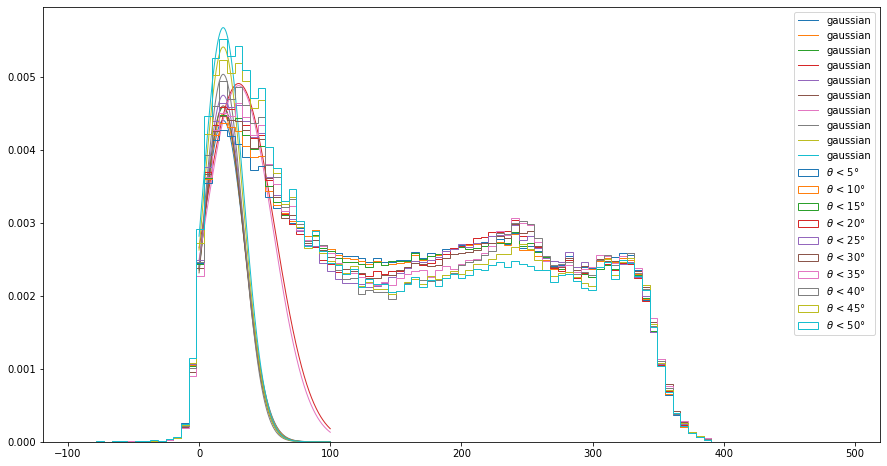

In [33]:
fig, ax = plt.subplots(figsize=(15,8))

gauss_up_peaks = []
lor_up_peaks = []
gauss_up_err = []

for p,b,err in zip(high_hists, high_hist_bins, high_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_up_peaks.append( popt_gauss[0] )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_up_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')


for h, theta in zip(high_hists, thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ < "+str(theta)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'])

ax.legend()

for p,e in zip(gauss_up_peaks, gauss_up_err):
    print(f'{p:.5f} pm {e:.5f}')


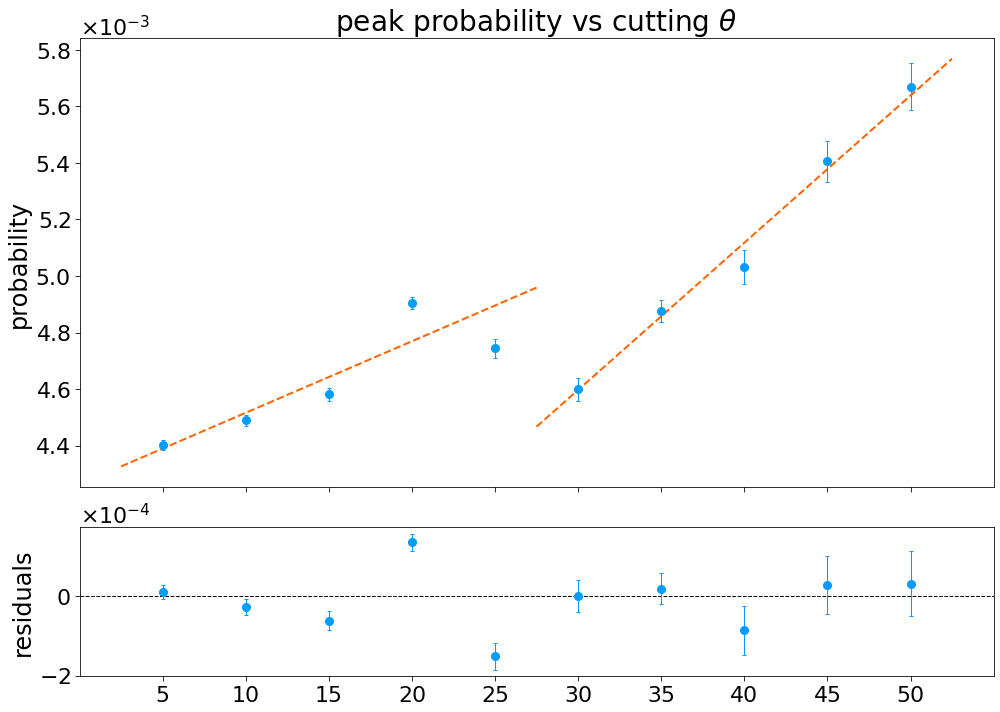

In [34]:
fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs cutting $\theta$", fontsize=28)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)
# ax1.set_xticks(thetas_low)
ax1.set_xticks(thetas)
ax2.set_xticks(thetas)
# ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(0, 55)
ax2.set_xlim(0, 55)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)


gauss_high_par, _ = curve_fit(
    f=lin,
    xdata=thetas[:5], 
    ydata=gauss_up_peaks[:5],
    sigma=gauss_up_err[:5],
    absolute_sigma=True
)


func = lin(np.array(thetas[0:5]), *gauss_high_par)
high_res = gauss_up_peaks[0:5] - func
chi_high_small = np.sum( ( high_res  / gauss_up_err[0:5] ) **2)
d_high_small = len(high_res) - len(gauss_high_par)
p_high_small = scipy.stats.chi2.sf(chi_high_small, df = d_high_small) 

theta_grid = np.linspace(thetas[0]-2.5, thetas[4]+2.5, 500)
ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_high_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

ax1.errorbar(
    x          = thetas, 
    y          = gauss_up_peaks,
    yerr       = gauss_up_err,
    marker     = "o",
    color      =  "#009cff",
    markersize = 8,
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

#  residuals
ax2.errorbar(
    x          = thetas[:5], 
    y          = high_res,
    yerr       = gauss_up_err[:5],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


gauss_high_par, _ = curve_fit(
    f=lin,
    xdata=thetas[5:], 
    ydata=gauss_up_peaks[5:],
    sigma=gauss_up_err[5:],
    absolute_sigma=True
)

func = lin(np.array(thetas[5:]), *gauss_high_par)
high_res = gauss_up_peaks[5:] - func
chi_high_large = np.sum( ( high_res  / gauss_up_err[5:] )**2)
d_high_large = len(high_res) - len(gauss_high_par)
p_high_large = scipy.stats.chi2.sf(chi_high_large, df = d_high_large)

theta_grid = np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 500)
ax1.plot(
    theta_grid, 
    lin(theta_grid, *gauss_high_par),
    linestyle = "dashed",
    color = "#ff6300", 
    lw=2,
)

#  residuals
ax2.errorbar(
    x          = thetas[5:], 
    y          = high_res,
    yerr       = gauss_up_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

fig.tight_layout()
PLOT_NAME = "density_gaus_high"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [137]:
low_r, low_p = scipy.stats.pearsonr(thetas[0:5], gauss_up_peaks[0:5])
high_r, high_p = scipy.stats.pearsonr(thetas[5:], gauss_up_peaks[5:])

print(f"Correlation coefficient {low_r:.5f}")
print(f"p-value = {low_p:.2e}")
print("Statistically significant:", "YES" if low_p < alpha else "NO")

print('Chi squared', chi_high_small)
print(f"p value of chi = {p_high_small}")

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

print('Chi squared', chi_high_large)
print(f"p value of chi = {p_high_large}")

Correlation coefficient 0.86299
p-value = 5.96e-02
Statistically significant: NO
Chi squared 67.51047078943905
p value of chi = 1.4561595487755474e-14
Correlation coefficient 0.99369
p-value = 6.02e-04
Statistically significant: YES
Chi squared 2.530182264086211
p value of chi = 0.4698611582811648


In [109]:
# # thetas_low = [0,10,20,30]
# # thetas_up = [10,20,30,40]
# # thetas_low = [0,5,10,15,20,25,30,35]
# # thetas_up = [5,10,15,20,25,30,35,40]

# # middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low,up in zip(thetas_low,thetas_up) ]

# gauss_middle_peaks = []
# gauss_middle_err = []

# fig, ax = plt.subplots(figsize=(15,8))

# for cut in middle_cut:
#     df_prova = df[ cut ]
#     p, b = np.histogram(df_prova.drift_time, bins=bins)
#     p_norm = normalize(p)
#     bin_centers = (b[1:]+b[:-1])/2

#     #incertezze sulle y cioè sulle probabilità:
#     norm = sum(p)
#     err = [np.sqrt(h / norm) for h in p_norm] #errore su tutti i p

#     DF = pd.DataFrame({'prob':p_norm, 'bin_cent':bin_centers, 'err':err})
#     DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
#     DF = DF.reset_index(drop=True)

#     prob_peak = DF['prob'].max()
#     bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
#     err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

#     first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
#     prob_first_half =  first_half_df['prob']
#     err_first_half = first_half_df['err']

#     bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

#     second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
#     second_half_df.columns = ['prob', 'bin_cent', 'err']
#     second_half_df['prob'] = second_half_df['prob'].values[::-1]
#     second_half_df['err'] = second_half_df['err'].values[::-1]

#     first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
#     final_df = first_half_df.append(second_half_df, ignore_index=True)
#     final_df = final_df[ final_df['prob']!=0 ]
    
#     popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
#     p0=[0.02, 20, 10], 
#     sigma=final_df['err'], 
#     absolute_sigma=True
#     )
#     # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

#     y_gauss = gaussian(xx,*popt_gauss)
#     gauss_middle_peaks.append( y_gauss.max() )

#     sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
#     #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
#     gauss_middle_err.append(sigma[0])
#     ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
#     ax.scatter(DF['bin_cent'], DF['prob'])

#     break

# for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low,thetas_up,):
#     ax.hist(
#         bins[:-1],
#         bins=bins,
#         weights=h,
#         histtype="step",
#         linewidth = 2,
#         label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
#     )
#     # ax.scatter(final_df['bin_cent'], final_df['prob'])

#     break
# ax.legend()

# # for p,e in zip(gauss_low_peaks, gauss_low_err):
# #     print(f'{p:.5f} pm {e:.5f}')


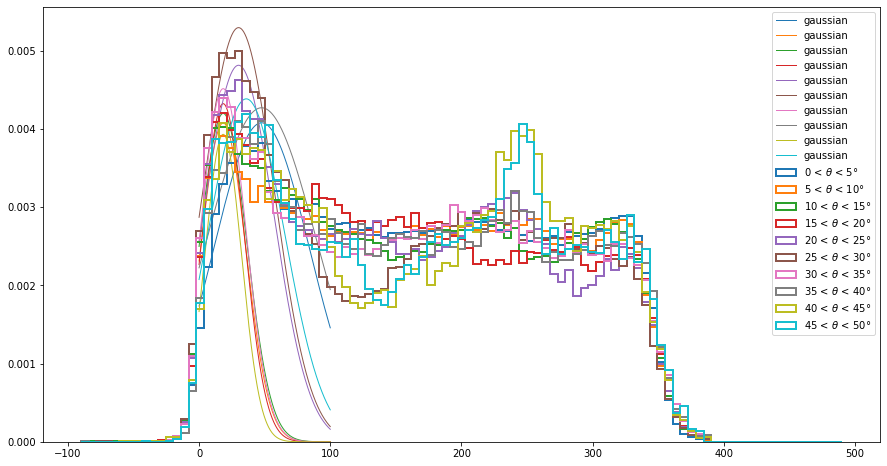

In [35]:
gauss_middle_peaks = []
gauss_middle_err = []

fig, ax = plt.subplots(figsize=(15,8))

for p,b,err in zip(middle_hists, middle_hist_bins, middle_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_middle_peaks.append( popt_gauss[0] )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_middle_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
    
    # ax.scatter(DF['bin_cent'], DF['prob'])
    # break

for h, theta_low, theta_up in zip(middle_hists, thetas_low, thetas_up,):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'])
    # break
ax.legend()



/var/folders/q3/r96zncz17lq5z2jf1vj44c700000gn/T/ipykernel_24911/3122892263.py:5: RuntimeWarning: overflow encountered in exp
  return a+b*np.exp(-c*x)


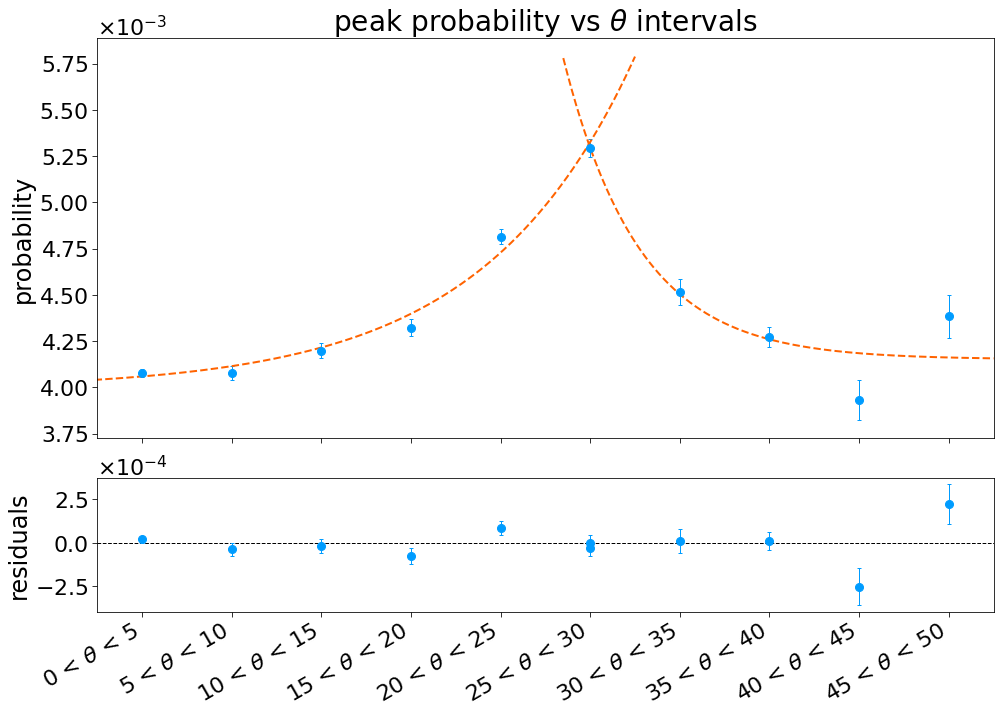

In [46]:
def expo(x, a, b, c):
    return a+b*np.exp(c*x)

def nexpo(x, a, b, c):
    return a+b*np.exp(-c*x)



thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
x_theta = np.linspace(-5,27.5,500)


xlabels = [r"%i < $\theta$ < %i"%(x1,x2) for x1, x2 in zip(thetas_low,thetas_up)]


fig, ax = plt.subplots(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title(r"peak probability vs $\theta$ intervals", fontsize=28)
ax1.set_ylabel("probability", fontsize=24)
ax2.set_ylabel("residuals", fontsize=24)
ax1.set_xticks(thetas_low)
ax2.set_xticks(thetas_low)
ax2.set_xticklabels(xlabels, rotation=30, ha="right")
ax1.set_xticklabels([])

ax1.set_xlim(-2.5, 47.5)
ax2.set_xlim(-2.5, 47.5)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax1.yaxis.get_offset_text().set_fontsize(22)
ax1.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax2.yaxis.get_offset_text().set_fontsize(22)
ax2.tick_params(axis="both", which="major", labelsize=22, length=5)

ax2.axhline(y=0, lw=1, color="black", linestyle="--",)

ax1.errorbar(
    x=thetas_low, 
    y=gauss_middle_peaks, 
    yerr=gauss_middle_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2
)

# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=expo, 
    xdata=thetas_low[:6], 
    ydata=gauss_middle_peaks[:6], 
    sigma=gauss_middle_err[:6], 
    absolute_sigma=True
)

# residuals
func = expo(np.array(thetas_low[:6]), *middle_par_tot)
middle_res = gauss_middle_peaks[:6] - func
chi_middle_large = np.sum( ( middle_res  / gauss_middle_err[:6] )**2)
d_middle_large = len(middle_res) - len(middle_par_tot)
p_middle_large = scipy.stats.chi2.sf(chi_middle_large, df = d_middle_large) 

#  residuals
ax2.errorbar(
    x          = thetas_low[:6], 
    y          = middle_res,
    yerr       = gauss_middle_err[:6],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)


ax1.plot(
    x_theta, 
    expo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)


# fitting data
middle_par_tot, _ = scipy.optimize.curve_fit(
    f=nexpo, 
    xdata=thetas_low[5:], 
    ydata=gauss_middle_peaks[5:], 
    sigma=gauss_middle_err[5:], 
    absolute_sigma=True
)

# residuals
func = nexpo(np.array(thetas_low[5:]), *middle_par_tot)
middle_res = gauss_middle_peaks[5:] - func
chi_middle_small = np.sum( ( middle_res  / gauss_middle_err[5:] )**2 )
d_middle_small = len(middle_res) - len(middle_par_tot)
p_middle_small = scipy.stats.chi2.sf(chi_middle_small, df = d_middle_small) 

#  residuals
ax2.errorbar(
    x          = thetas_low[5:], 
    y          = middle_res,
    yerr       = gauss_middle_err[5:],
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    # label      = r"cut: $\theta$ < x"
)

x_theta = np.linspace(23.5,47.5,500)

ax1.plot(
    x_theta, 
    nexpo(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)

# ax2.set_ylim(-2.3e-3,2.3e-3)

fig.tight_layout()

PLOT_NAME = "density_gaus_intervals"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

In [142]:

high_r, high_p = scipy.stats.pearsonr(thetas_low, gauss_middle_peaks)
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.4f}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

print("chi squared", chi_middle_small)
print(f"p value of chi = {p_middle_large}")

print("chi squared", chi_middle_large)
print(f"p value of chi = {p_high_small}")


Correlation coefficient 0.14256
p-value = 0.6944
Statistically significant: NO
chi squared 9.4778770696727
p value of chi = 0.02073721983357938
chi squared 9.758219658391072
p value of chi = 1.4561595487755474e-14
